In [1]:
%load_ext autoreload
%autoreload 2

In [159]:
from modules import data_loader, metrics, plotting, utils, params, learning
from modules.gmp_model import GMP
from modules.nn_model import GRU
import matplotlib.pyplot as plt
import numpy as np

from modules.pipelines import SimplePipeline, SnrPipeline


Load data from files and init acpr meter

In [73]:
data = data_loader.load_data("DPA_200MHz")

config = data["config"]
fs = config["input_signal_fs"]
bw_main_ch = config["bw_main_ch"]
bw_sub_ch = config["bw_sub_ch"]
n_sub_ch = config["n_sub_ch"]
sub_ch = config["sub_ch"]
nperseg = config["nperseg"]

x_train = data["train_input"]
y_train = data["train_output"]
x_val = data["val_input"]
y_val = data["val_output"]

gain = metrics.calculate_gain_complex(x_train, y_train)
print(f"Gain of PA = {gain:.2f}")
y_train_target = gain * x_train
y_val_target = gain * x_val

data['y_train_target'] = y_train_target
data['y_val_target'] = y_val_target

acpr_meter = metrics.ACPR(
        sample_rate=fs,
        main_measurement_bandwidth=bw_main_ch,
        adjacent_channel_offset=[-sub_ch, sub_ch],
        segment_length=nperseg,
        overlap_percentage=60,
        window='blackmanharris',
        fft_length=nperseg,
        power_units='dBW',
        return_main_power=True,
        return_adjacent_powers=True
    )


gmp_train_props = {
    "gmp_degree": 5,
    "lr": 0.01,
    "epochs": 1000,
    "acpr_meter": acpr_meter
}

nn_train_props = {
    "hidden_size": 8, 
    "num_layers": 1,
    "lr": 0.001,
    "epochs": 100,
    "acpr_meter": acpr_meter
}

Gain of PA = 2.52


In [47]:
gmp_pipeline = SimplePipeline(data_dict=data, 
                              train_props=gmp_train_props, 
                              base_model=GMP)
gmp_pipeline.run()

[PA] Calculated gain: 2.52
Run PA
Coefficients loaded from model_params/pa_gmp_model_Ka5_La5_Kb5_Lb5_Mb5_Kc5_Lc5_Mc5.pt
[PA] NMSE: -32.98, ACPR: [-43.6778176 -41.4680787]
Run DLA
Coefficients loaded from model_params/dla_gmp_model_Ka5_La5_Kb5_Lb5_Mb5_Kc5_Lc5_Mc5.pt
[DLA] NMSE: -49.59, ACPR: [-47.57345618 -48.00886752]
Run ILA
Coefficients loaded from model_params/ila_gmp_model_Ka5_La5_Kb5_Lb5_Mb5_Kc5_Lc5_Mc5.pt
[ILA] NMSE: -47.57, ACPR: [-47.26684709 -47.72345492]
Run ILC
Epoch [0/500], Loss: 0.030477918684482574
Epoch [100/500], Loss: 0.0010683428263291717
Epoch [200/500], Loss: 2.9619668566738255e-05
Epoch [300/500], Loss: 6.954932700864447e-07
Epoch [400/500], Loss: 3.9306566890218164e-08
Epoch [499/500], Loss: 1.1791987830633843e-08
Время расчёта ilc_signal: 0:01:31
[UK] NMSE: -78.13, ACPR: [-50.93274422 -50.36784216]
Coefficients loaded from model_params/ilc_gmp_model_Ka5_La5_Kb5_Lb5_Mb5_Kc5_Lc5_Mc5.pt
[ILC] NMSE: -49.25, ACPR: [-47.23755007 -48.15639658]


In [23]:
gmp_results = gmp_pipeline.get_results()

gmp_pa_nmse = gmp_results["pa"]["nmse"]
gmp_pa_acpr = gmp_results["pa"]["acpr"]
gmp_y_val_pa = gmp_results["pa"]["y_val_pa_model"]

gmp_dla_nmse = gmp_results["dla"]["nmse"]
gmp_dla_acpr = gmp_results["dla"]["acpr"]
gmp_y_val_dla = gmp_results["dla"]["y_val_dla"]

gmp_ila_nmse = gmp_results["ila"]["nmse"]
gmp_ila_acpr = gmp_results["ila"]["acpr"]
gmp_y_val_ila = gmp_results["ila"]["y_val_ila"]

gmp_ilc_nmse = gmp_results["ilc"]["nmse"]
gmp_ilc_acpr = gmp_results["ilc"]["acpr"]
gmp_y_val_ilc = gmp_results["ilc"]["y_val_ilc"]

gmp_uk_nmse = gmp_results["uk"]["nmse"]
gmp_uk_acpr = gmp_results["uk"]["acpr"]
gmp_u_k_train = gmp_results["uk"]["u_k_train"]
gmp_u_k_pa = gmp_results["uk"]["u_k_pa"]

gmp_pa_model = gmp_pipeline.get_pa_model()


In [75]:
gru_pipeline = SimplePipeline(data_dict=data, 
                              train_props=nn_train_props, 
                              base_model=GRU)


[PA] Calculated gain: 2.52


In [76]:
gru_pipeline.run_pa()

Run PA
No saved weights found at model_params/pa_gru_model_hs8_nl1_in2_out2.pt, initializing new parameters.
===Start training===
Epoch 0000 — train_loss: 0.524854, val_loss: 0.392188, val_NMSE: -4.97
Epoch 0001 — train_loss: 0.244883, val_loss: 0.075469, val_NMSE: -12.13
Epoch 0002 — train_loss: 0.055049, val_loss: 0.010680, val_NMSE: -20.62
Epoch 0003 — train_loss: 0.020535, val_loss: 0.004593, val_NMSE: -24.28
Epoch 0004 — train_loss: 0.011422, val_loss: 0.003049, val_NMSE: -26.06
Epoch 0005 — train_loss: 0.007274, val_loss: 0.002428, val_NMSE: -27.05
Epoch 0006 — train_loss: 0.005102, val_loss: 0.002124, val_NMSE: -27.63
Epoch 0007 — train_loss: 0.003939, val_loss: 0.001893, val_NMSE: -28.13
Epoch 0008 — train_loss: 0.003338, val_loss: 0.001763, val_NMSE: -28.44
Epoch 0009 — train_loss: 0.003040, val_loss: 0.001676, val_NMSE: -28.66
Epoch 0010 — train_loss: 0.002887, val_loss: 0.001627, val_NMSE: -28.79
Epoch 0011 — train_loss: 0.002799, val_loss: 0.001558, val_NMSE: -28.98
Epoch 0

In [77]:
gru_pipeline.run_dla()

Run DLA
No saved weights found at model_params/dla_gru_model_hs8_nl1_in2_out2.pt, initializing new parameters.
===Start training===
Epoch 0000 — train_loss: 0.269001, val_loss: 0.106206, val_NMSE: -8.66
Epoch 0001 — train_loss: 0.040988, val_loss: 0.004558, val_NMSE: -22.33
Epoch 0002 — train_loss: 0.005436, val_loss: 0.001028, val_NMSE: -28.80
Epoch 0003 — train_loss: 0.002577, val_loss: 0.000912, val_NMSE: -29.32
Epoch 0004 — train_loss: 0.001785, val_loss: 0.000804, val_NMSE: -29.87
Epoch 0005 — train_loss: 0.001346, val_loss: 0.000721, val_NMSE: -30.34
Epoch 0006 — train_loss: 0.001062, val_loss: 0.000642, val_NMSE: -30.85
Epoch 0007 — train_loss: 0.000873, val_loss: 0.000577, val_NMSE: -31.31
Epoch 0008 — train_loss: 0.000750, val_loss: 0.000556, val_NMSE: -31.47
Epoch 0009 — train_loss: 0.000676, val_loss: 0.000530, val_NMSE: -31.68
Epoch 0010 — train_loss: 0.000628, val_loss: 0.000515, val_NMSE: -31.80
Epoch 0011 — train_loss: 0.000592, val_loss: 0.000487, val_NMSE: -32.05
Epoch

In [78]:
gru_pipeline.run_ila()

Run ILA
No saved weights found at model_params/ila_gru_model_hs8_nl1_in2_out2.pt, initializing new parameters.
===Start training===
Epoch 0000 — train_loss: 0.075280, val_loss: 0.026158, val_NMSE: -6.71
Epoch 0001 — train_loss: 0.015112, val_loss: 0.005112, val_NMSE: -13.80
Epoch 0002 — train_loss: 0.003926, val_loss: 0.001159, val_NMSE: -20.25
Epoch 0003 — train_loss: 0.001551, val_loss: 0.000479, val_NMSE: -24.09
Epoch 0004 — train_loss: 0.000946, val_loss: 0.000385, val_NMSE: -25.03
Epoch 0005 — train_loss: 0.000718, val_loss: 0.000339, val_NMSE: -25.59
Epoch 0006 — train_loss: 0.000577, val_loss: 0.000306, val_NMSE: -26.03
Epoch 0007 — train_loss: 0.000476, val_loss: 0.000278, val_NMSE: -26.45
Epoch 0008 — train_loss: 0.000403, val_loss: 0.000257, val_NMSE: -26.80
Epoch 0009 — train_loss: 0.000351, val_loss: 0.000236, val_NMSE: -27.16
Epoch 0010 — train_loss: 0.000313, val_loss: 0.000219, val_NMSE: -27.48
Epoch 0011 — train_loss: 0.000286, val_loss: 0.000205, val_NMSE: -27.78
Epoch

In [79]:
gru_pipeline.run_ilc()

Run ILC
Epoch [0/200], Loss: 0.03027859330177307
Epoch [100/200], Loss: 3.3691696899040835e-07
Epoch [199/200], Loss: 1.1786793763235437e-11
Время расчёта ilc_signal: 0:14:27
[UK] NMSE: -108.52, ACPR: [-50.93603594 -50.36959302]
No saved weights found at model_params/ilc_gru_model_hs8_nl1_in2_out2.pt, initializing new parameters.
===Start training===
Epoch 0000 — train_loss: 0.031240, val_loss: 0.052776, val_NMSE: -1.61
Epoch 0001 — train_loss: 0.007016, val_loss: 0.074061, val_NMSE: -0.14
Epoch 0002 — train_loss: 0.001517, val_loss: 0.077744, val_NMSE: 0.07
Epoch 0003 — train_loss: 0.000571, val_loss: 0.078645, val_NMSE: 0.12
Epoch 0004 — train_loss: 0.000362, val_loss: 0.078926, val_NMSE: 0.14
Epoch 0005 — train_loss: 0.000271, val_loss: 0.079047, val_NMSE: 0.14
Epoch 0006 — train_loss: 0.000217, val_loss: 0.078961, val_NMSE: 0.14
Epoch 0007 — train_loss: 0.000186, val_loss: 0.078816, val_NMSE: 0.13
Epoch 0008 — train_loss: 0.000168, val_loss: 0.078928, val_NMSE: 0.14
Epoch 0009 — tr

In [80]:
gru_results = gru_pipeline.get_results()

gru_pa_nmse = gru_results["pa"]["nmse"]
gru_pa_acpr = gru_results["pa"]["acpr"]
gru_y_val_pa = gru_results["pa"]["y_val_pa_model"]

gru_dla_nmse = gru_results["dla"]["nmse"]
gru_dla_acpr = gru_results["dla"]["acpr"]
gru_y_val_dla = gru_results["dla"]["y_val_dla"]

gru_ila_nmse = gru_results["ila"]["nmse"]
gru_ila_acpr = gru_results["ila"]["acpr"]
gru_y_val_ila = gru_results["ila"]["y_val_ila"]

gru_ilc_nmse = gru_results["ilc"]["nmse"]
gru_ilc_acpr = gru_results["ilc"]["acpr"]
gru_y_val_ilc = gru_results["ilc"]["y_val_ilc"]

gru_uk_nmse = gru_results["uk"]["nmse"]
gru_uk_acpr = gru_results["uk"]["acpr"]
gru_u_k_train = gru_results["uk"]["u_k_train"]
gru_u_k_pa = gru_results["uk"]["u_k_pa"]

gru_pa_model = gru_pipeline.get_pa_model()


Metrics

In [165]:
gmp_y_val_pa = learning.net_inference(net=gmp_pa_model, x=x_val)
gmp_pa_target_nmse = metrics.compute_nmse(gmp_y_val_pa, y_val_target)

print(f"GMP NMSE на выходе усилителя (без DPD): {gmp_pa_target_nmse:.2f} db")
print(f"GMP NMSE на выходе усилителя (DLA DPD): {gmp_dla_nmse:.2f} db")
print(f"GMP NMSE на выходе усилителя (ILA DPD): {gmp_ila_nmse:.2f} db")
print(f"GMP NMSE на выходе усилителя (ILC DPD): {gmp_ilc_nmse:.2f} db")
print(f"GMP NMSE на выходе усилителя (ILC):     {gmp_uk_nmse:.2f} db")
print()

gru_y_val_pa = learning.net_inference(net=gru_pa_model, x=x_val)
gru_pa_target_nmse = metrics.compute_nmse(gru_y_val_pa, y_val_target)

print(f"GRU NMSE на выходе усилителя (без DPD): {gru_pa_target_nmse:.2f} db")
print(f"GRU NMSE на выходе усилителя (DLA DPD): {gru_dla_nmse:.2f} db")
print(f"GRU NMSE на выходе усилителя (ILA DPD): {gru_ila_nmse:.2f} db")
print(f"GRU NMSE на выходе усилителя (ILC DPD): {gru_ilc_nmse:.2f} db")
print(f"GRU NMSE на выходе усилителя (ILC):     {gru_uk_nmse:.2f} db")

GMP NMSE на выходе усилителя (без DPD): -14.12 db
GMP NMSE на выходе усилителя (DLA DPD): -49.59 db
GMP NMSE на выходе усилителя (ILA DPD): -47.57 db
GMP NMSE на выходе усилителя (ILC DPD): -49.25 db
GMP NMSE на выходе усилителя (ILC):     -78.13 db

GRU NMSE на выходе усилителя (без DPD): -14.15 db
GRU NMSE на выходе усилителя (DLA DPD): -41.61 db
GRU NMSE на выходе усилителя (ILA DPD): -43.56 db
GRU NMSE на выходе усилителя (ILC DPD): -41.62 db
GRU NMSE на выходе усилителя (ILC):     -108.52 db


In [166]:
y_in_acpr = metrics.calculate_acpr(x_val, acpr_meter)
y_out_acpr = metrics.calculate_acpr(y_val, acpr_meter)
y_val_target_acpr = metrics.calculate_acpr(y_val_target, acpr_meter)


print(f"y_in_acpr: {y_in_acpr}")
print(f"y_out_acpr: {y_out_acpr}")
print(f"y_val_target_acpr: {y_val_target_acpr}")
print()
print(f"gmp_pa_acpr: {gmp_pa_acpr}")
print(f"gmp_dla_acpr: {gmp_dla_acpr}")
print(f"gmp_ila_acpr: {gmp_ila_acpr}")
print(f"gmp_ilc_acpr: {gmp_ilc_acpr}")
print(f"gmp_uk_acpr: {gmp_uk_acpr}")
print()
print(f"gru_pa_acpr: {gru_pa_acpr}")
print(f"gru_dla_acpr: {gru_dla_acpr}")
print(f"gru_ila_acpr: {gru_ila_acpr}")
print(f"gru_ilc_acpr: {gru_ilc_acpr}")
print(f"gru_uk_acpr: {gru_uk_acpr}")

y_in_acpr: [-48.08083195 -48.40122574]
y_out_acpr: [-40.60778184 -38.20237847]
y_val_target_acpr: [-48.08083304 -48.40122404]

gmp_pa_acpr: [-43.6778176 -41.4680787]
gmp_dla_acpr: [-47.57345618 -48.00886752]
gmp_ila_acpr: [-47.26684709 -47.72345492]
gmp_ilc_acpr: [-47.23755007 -48.15639658]
gmp_uk_acpr: [-50.93274422 -50.36784216]

gru_pa_acpr: [-43.08757349 -42.68970018]
gru_dla_acpr: [-46.95070951 -46.94095641]
gru_ila_acpr: [-47.60190886 -47.35413546]
gru_ilc_acpr: [-46.10228259 -46.71398514]
gru_uk_acpr: [-50.93603594 -50.36959302]


Spectrum

In [85]:
freqs, spectrum_y_in = metrics.power_spectrum(x_val, fs, nperseg)
_, spectrum_y_out = metrics.power_spectrum(y_val, fs, nperseg)
_, spectrum_y_val_target = metrics.power_spectrum(y_val_target, fs, nperseg)

_, spectrum_gmp_y_val_pa = metrics.power_spectrum(gmp_y_val_pa, fs, nperseg)
_, spectrum_gmp_y_val_dla = metrics.power_spectrum(gmp_y_val_dla, fs, nperseg)
_, spectrum_gmp_y_val_ila = metrics.power_spectrum(gmp_y_val_ila, fs, nperseg)
_, spectrum_gmp_y_val_ilc = metrics.power_spectrum(gmp_y_val_ilc, fs, nperseg)
_, spectrum_gmp_u_k = metrics.power_spectrum(gmp_u_k_train, fs, nperseg)
_, spectrum_gmp_u_k_pa = metrics.power_spectrum(gmp_u_k_pa, fs, nperseg)

_, spectrum_gru_y_val_pa = metrics.power_spectrum(gru_y_val_pa, fs, nperseg)
_, spectrum_gru_y_val_dla = metrics.power_spectrum(gru_y_val_dla, fs, nperseg)
_, spectrum_gru_y_val_ila = metrics.power_spectrum(gru_y_val_ila, fs, nperseg)
_, spectrum_gru_y_val_ilc = metrics.power_spectrum(gru_y_val_ilc, fs, nperseg)
_, spectrum_gru_u_k = metrics.power_spectrum(gru_u_k_train, fs, nperseg)
_, spectrum_gru_u_k_pa = metrics.power_spectrum(gru_u_k_pa, fs, nperseg)

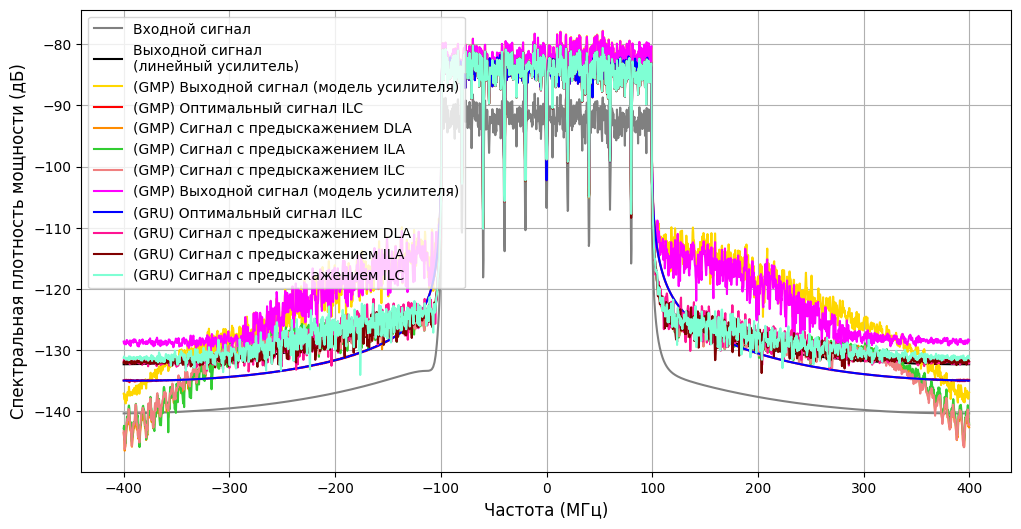

In [176]:
# построение спектра

xlabel="Частота (МГц)"
ylabel= "Спектральная плотность мощности (дБ)"
fontsize = 12
figsize=(12, 6)

plt.figure(figsize=figsize)

plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_in)), color='grey', label='Входной сигнал')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_val_target)), 
         color='black', label='Выходной сигнал\n(линейный усилитель)')

plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_gmp_y_val_pa)), color='gold', label='(GMP) Выходной сигнал (модель усилителя)')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_gmp_u_k_pa)), color='red', label='(GMP) Оптимальный сигнал ILC')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_gmp_y_val_dla)), color='darkorange', label='(GMP) Сигнал с предыскажением DLA')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_gmp_y_val_ila)), color='limegreen', label='(GMP) Сигнал с предыскажением ILA')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_gmp_y_val_ilc)), color='lightcoral', label='(GMP) Сигнал с предыскажением ILC')

plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_gru_y_val_pa)), color='magenta', label='(GMP) Выходной сигнал (модель усилителя)')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_gru_u_k_pa)), color='blue', label='(GRU) Оптимальный сигнал ILC')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_gru_y_val_dla)), color='deeppink', label='(GRU) Сигнал с предыскажением DLA')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_gru_y_val_ila)), color='maroon', label='(GRU) Сигнал с предыскажением ILA')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_gru_y_val_ilc)), color='aquamarine', label='(GRU) Сигнал с предыскажением ILC')


plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.legend()
plt.grid()
plt.show()



In [177]:
# moving_average
window_size = 60

freqs_s, spectrum_y_in_s = utils.moving_average(spectrum_y_in, freqs, fs, window_size)
_, spectrum_y_out_s = utils.moving_average(spectrum_y_out, freqs, fs, window_size)
_, spectrum_y_val_target_s = utils.moving_average(spectrum_y_val_target, freqs, fs, window_size)

_, spectrum_gmp_y_val_pa_s = utils.moving_average(spectrum_gmp_y_val_pa, freqs, fs, window_size)
_, spectrum_gmp_y_val_dla_s = utils.moving_average(spectrum_gmp_y_val_dla, freqs, fs, window_size)
_, spectrum_gmp_y_val_ila_s = utils.moving_average(spectrum_gmp_y_val_ila, freqs, fs, window_size)
_, spectrum_gmp_y_val_ilc_s = utils.moving_average(spectrum_gmp_y_val_ilc, freqs, fs, window_size)
_, spectrum_gmp_u_k_s = utils.moving_average(spectrum_gmp_u_k, freqs, fs, window_size)
_, spectrum_gmp_u_k_pa_s = utils.moving_average(spectrum_gmp_u_k_pa, freqs, fs, window_size)


_, spectrum_gru_y_val_pa_s = utils.moving_average(spectrum_gru_y_val_pa, freqs, fs, window_size)
_, spectrum_gru_y_val_dla_s = utils.moving_average(spectrum_gru_y_val_dla, freqs, fs, window_size)
_, spectrum_gru_y_val_ila_s = utils.moving_average(spectrum_gru_y_val_ila, freqs, fs, window_size)
_, spectrum_gru_y_val_ilc_s = utils.moving_average(spectrum_gru_y_val_ilc, freqs, fs, window_size)
_, spectrum_gru_u_k_s = utils.moving_average(spectrum_gru_u_k, freqs, fs, window_size)
_, spectrum_gru_u_k_pa_s = utils.moving_average(spectrum_gru_u_k_pa, freqs, fs, window_size)


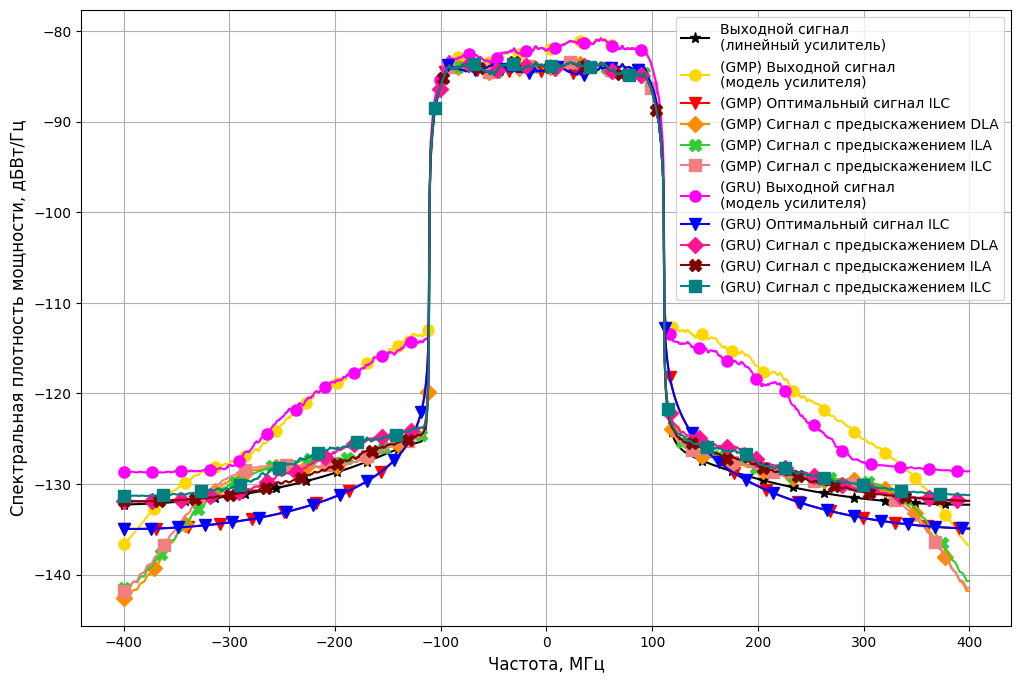

In [178]:
# (сглаженный) построение спектра

xlabel="Частота, МГц"
ylabel= "Спектральная плотность мощности, дБВт/Гц"
fontsize = 12
figsize=(12, 8)
markersize=8

plt.figure(figsize=figsize)

# plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_in_s)), 
#          color='grey', label='Входной сигнал',marker = '*', markevery=90, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_val_target_s)), 
         color='black', label='Выходной сигнал\n(линейный усилитель)',marker = '*', markevery=90, markersize=markersize)

plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_gmp_y_val_pa_s)), 
         color='gold', label='(GMP) Выходной сигнал\n(модель усилителя)', marker='o', markevery=90, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_gmp_u_k_pa_s)), 
         color='red', label='(GMP) Оптимальный сигнал ILC', marker='v', markevery=95, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_gmp_y_val_dla_s)), 
         color='darkorange', label='(GMP) Сигнал с предыскажением DLA', marker='D', markevery=90, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_gmp_y_val_ila_s)), 
         color='limegreen', label='(GMP) Сигнал с предыскажением ILA', marker='X', markevery=110, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_gmp_y_val_ilc_s)), 
         color='lightcoral', label='(GMP) Сигнал с предыскажением ILC', marker='s', markevery=120, markersize=markersize)

plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_gru_y_val_pa_s)), 
         color='magenta', label='(GRU) Выходной сигнал\n(модель усилителя)', marker='o', markevery=85, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_gru_u_k_pa_s)), 
         color='blue', label='(GRU) Оптимальный сигнал ILC', marker='v', markevery=80, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_gru_y_val_dla_s)), 
         color='deeppink', label='(GRU) Сигнал с предыскажением DLA', marker='D', markevery=85, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_gru_y_val_ila_s)), 
         color='maroon', label='(GRU) Сигнал с предыскажением ILA', marker='X', markevery=105, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_gru_y_val_ilc_s)), 
         color='teal', label='(GRU) Сигнал с предыскажением ILC', marker='s', markevery=115, markersize=markersize)

plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
# plt.xlim(-200, 200)
plt.legend()
plt.grid()
plt.show()


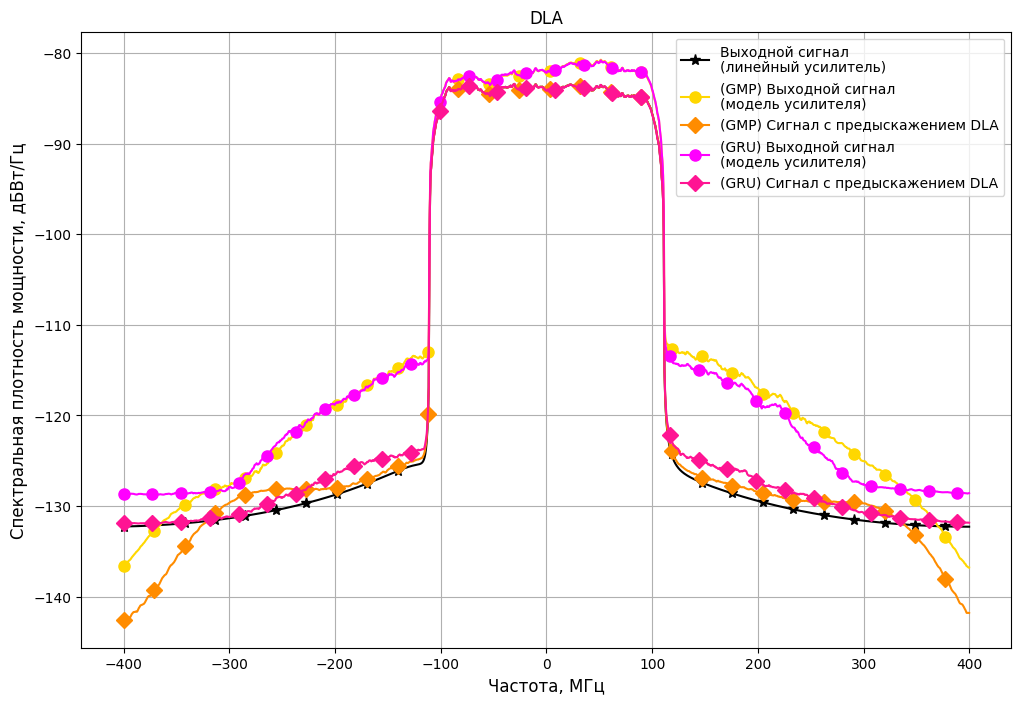

In [180]:
# DLA

xlabel="Частота, МГц"
ylabel= "Спектральная плотность мощности, дБВт/Гц"
fontsize = 12
figsize=(12, 8)
markersize=8

plt.figure(figsize=figsize)

# plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_in_s)), 
#          color='grey', label='Входной сигнал',marker = '*', markevery=90, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_val_target_s)), 
         color='black', label='Выходной сигнал\n(линейный усилитель)',marker = '*', markevery=90, markersize=markersize)

plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_gmp_y_val_pa_s)), 
         color='gold', label='(GMP) Выходной сигнал\n(модель усилителя)', marker='o', markevery=90, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_gmp_y_val_dla_s)), 
         color='darkorange', label='(GMP) Сигнал с предыскажением DLA', marker='D', markevery=90, markersize=markersize)

plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_gru_y_val_pa_s)), 
         color='magenta', label='(GRU) Выходной сигнал\n(модель усилителя)', marker='o', markevery=85, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_gru_y_val_dla_s)), 
         color='deeppink', label='(GRU) Сигнал с предыскажением DLA', marker='D', markevery=85, markersize=markersize)


plt.title("DLA")
plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.legend()
plt.grid()
plt.show()


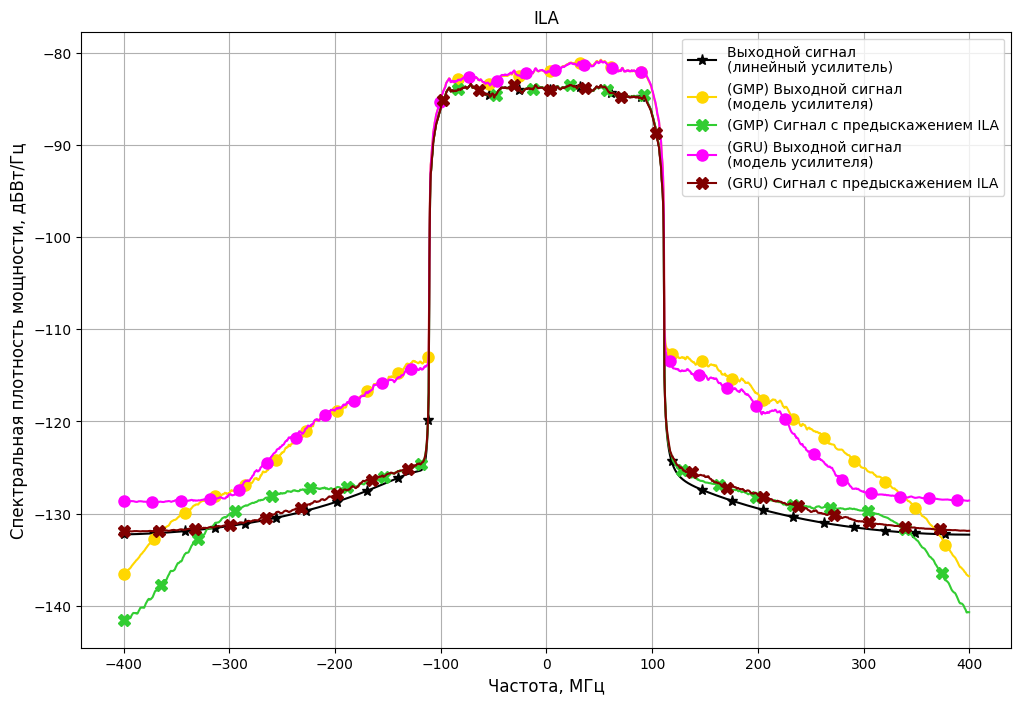

In [117]:
# ILA

xlabel="Частота, МГц"
ylabel= "Спектральная плотность мощности, дБВт/Гц"
fontsize = 12
figsize=(12, 8)
markersize=8

plt.figure(figsize=figsize)

# plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_in_s)), 
#          color='grey', label='Входной сигнал',marker = '*', markevery=90, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_val_target_s)), 
         color='black', label='Выходной сигнал\n(линейный усилитель)',marker = '*', markevery=90, markersize=markersize)

plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_gmp_y_val_pa_s)), 
         color='gold', label='(GMP) Выходной сигнал\n(модель усилителя)', marker='o', markevery=90, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_gmp_y_val_ila_s)), 
         color='limegreen', label='(GMP) Сигнал с предыскажением ILA', marker='X', markevery=110, markersize=markersize)

plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_gru_y_val_pa_s)), 
         color='magenta', label='(GRU) Выходной сигнал\n(модель усилителя)', marker='o', markevery=85, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_gru_y_val_ila_s)), 
         color='maroon', label='(GRU) Сигнал с предыскажением ILA', marker='X', markevery=105, markersize=markersize)


plt.title("ILA")
plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.legend()
plt.grid()
plt.show()


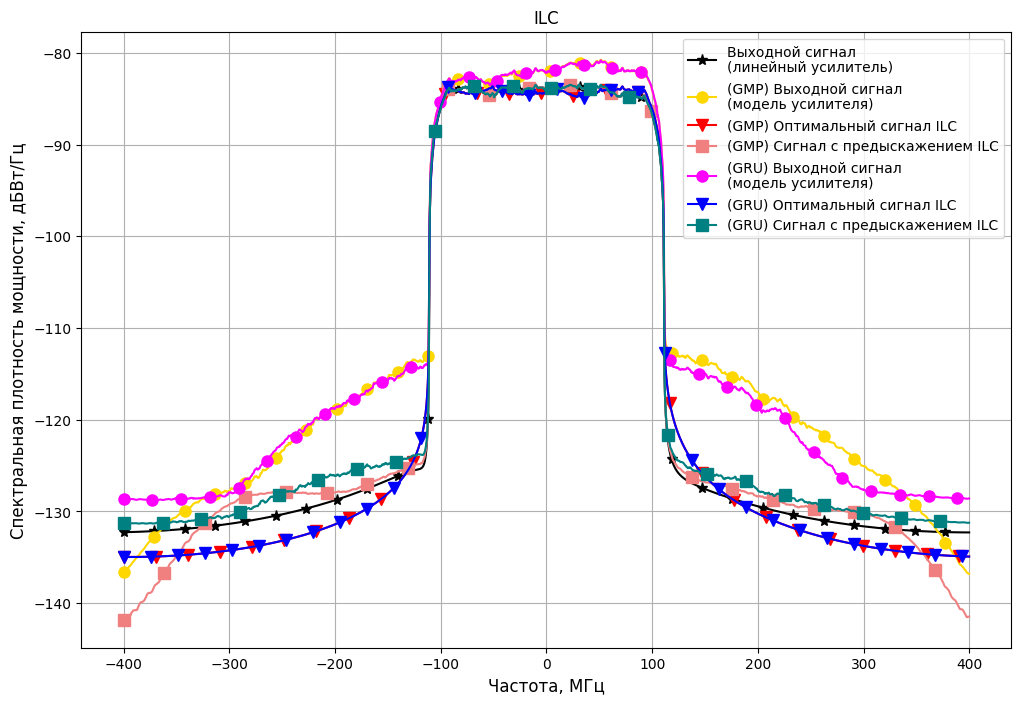

In [120]:
# ILC

xlabel="Частота, МГц"
ylabel= "Спектральная плотность мощности, дБВт/Гц"
fontsize = 12
figsize=(12, 8)
markersize=8

plt.figure(figsize=figsize)

# plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_in_s)), 
#          color='grey', label='Входной сигнал',marker = '*', markevery=90, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_val_target_s)), 
         color='black', label='Выходной сигнал\n(линейный усилитель)',marker = '*', markevery=90, markersize=markersize)

plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_gmp_y_val_pa_s)), 
         color='gold', label='(GMP) Выходной сигнал\n(модель усилителя)', marker='o', markevery=90, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_gmp_u_k_pa_s)), 
         color='red', label='(GMP) Оптимальный сигнал ILC', marker='v', markevery=95, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_gmp_y_val_ilc_s)), 
         color='lightcoral', label='(GMP) Сигнал с предыскажением ILC', marker='s', markevery=120, markersize=markersize)

plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_gru_y_val_pa_s)), 
         color='magenta', label='(GRU) Выходной сигнал\n(модель усилителя)', marker='o', markevery=85, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_gru_u_k_pa_s)), 
         color='blue', label='(GRU) Оптимальный сигнал ILC', marker='v', markevery=80, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_gru_y_val_ilc_s)), 
         color='teal', label='(GRU) Сигнал с предыскажением ILC', marker='s', markevery=115, markersize=markersize)

plt.title("ILC")
plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.legend()
plt.grid()
plt.show()


Add noise

In [98]:
snr_range = list(range(20, 61, 5))

gmp_snr_params = params.make_snr_params(
    snr_range=snr_range,
    num_realizations=500,
    fs=fs,
    bw_main_ch=bw_main_ch,
    epochs=500,
    learning_rate=0.01,
    acpr_meter=acpr_meter,
    pa_model=gmp_pa_model,
    gain=gain
)

gmp_degree = 5
gmp_params = {"gmp_degree": gmp_degree}



gru_snr_params = params.make_snr_params(
    snr_range=snr_range,
    num_realizations=500,
    fs=fs,
    bw_main_ch=bw_main_ch,
    epochs=100,
    learning_rate=0.001,
    acpr_meter=acpr_meter,
    pa_model=gru_pa_model,
    gain=gain
)

hidden_size=8
num_layers=1

nn_params = {
    "hidden_size": hidden_size,
    "num_layers": num_layers
}


In [111]:
gmp_snr_metrics_runner = SnrPipeline(base_model=GMP, 
                                           input_model_params=gmp_params, 
                                           data_dict=data, 
                                           snr_params=gmp_snr_params)

In [112]:
gmp_snr_metrics_runner.run(arch_name="DLA")

SNR: 20
===Start training===
Epoch 0000 — train_loss: 0.383380, val_loss: 0.508745, val_NMSE: -1.86
Epoch 0001 — train_loss: 0.479217, val_loss: 0.158232, val_NMSE: -6.93
Epoch 0002 — train_loss: 0.154119, val_loss: 0.161193, val_NMSE: -6.85
Epoch 0003 — train_loss: 0.152999, val_loss: 0.326513, val_NMSE: -3.78
Epoch 0004 — train_loss: 0.302720, val_loss: 0.320975, val_NMSE: -3.86
Epoch 0005 — train_loss: 0.300815, val_loss: 0.198545, val_NMSE: -5.94
Epoch 0006 — train_loss: 0.185445, val_loss: 0.080758, val_NMSE: -9.85
Epoch 0007 — train_loss: 0.077094, val_loss: 0.065877, val_NMSE: -10.73
Epoch 0008 — train_loss: 0.064949, val_loss: 0.116847, val_NMSE: -8.25
Epoch 0009 — train_loss: 0.111597, val_loss: 0.140608, val_NMSE: -7.44
Epoch 0010 — train_loss: 0.132151, val_loss: 0.107554, val_NMSE: -8.60
Epoch 0011 — train_loss: 0.102674, val_loss: 0.072512, val_NMSE: -10.32
Epoch 0012 — train_loss: 0.069427, val_loss: 0.069580, val_NMSE: -10.50
Epoch 0013 — train_loss: 0.067708, val_loss: 

In [113]:
gmp_snr_metrics_runner.run(arch_name="ILA")

SNR: 20
===Start training===
Epoch 0000 — train_loss: 0.060363, val_loss: 0.097562, val_NMSE: -1.00
Epoch 0001 — train_loss: 0.092687, val_loss: 0.027793, val_NMSE: -6.45
Epoch 0002 — train_loss: 0.027838, val_loss: 0.038692, val_NMSE: -5.01
Epoch 0003 — train_loss: 0.037416, val_loss: 0.065626, val_NMSE: -2.72
Epoch 0004 — train_loss: 0.060260, val_loss: 0.049902, val_NMSE: -3.91
Epoch 0005 — train_loss: 0.046071, val_loss: 0.019740, val_NMSE: -7.94
Epoch 0006 — train_loss: 0.018456, val_loss: 0.010405, val_NMSE: -10.72
Epoch 0007 — train_loss: 0.010161, val_loss: 0.021785, val_NMSE: -7.51
Epoch 0008 — train_loss: 0.020479, val_loss: 0.030430, val_NMSE: -6.06
Epoch 0009 — train_loss: 0.028306, val_loss: 0.024641, val_NMSE: -6.97
Epoch 0010 — train_loss: 0.022811, val_loss: 0.013998, val_NMSE: -9.43
Epoch 0011 — train_loss: 0.013342, val_loss: 0.009455, val_NMSE: -11.13
Epoch 0012 — train_loss: 0.009367, val_loss: 0.011150, val_NMSE: -10.42
Epoch 0013 — train_loss: 0.010886, val_loss: 

In [114]:
gmp_snr_metrics_runner.run(arch_name="ILC")

SNR: 20
Epoch [0/500], Loss: 0.05504536256194115
Epoch [100/500], Loss: 0.018418626859784126
Epoch [200/500], Loss: 0.014981386251747608
Epoch [300/500], Loss: 0.014901643618941307
Epoch [400/500], Loss: 0.014751747250556946
Epoch [499/500], Loss: 0.01485775038599968
Время расчёта ilc_signal: 0:01:16
===Start training===
Epoch 0000 — train_loss: 0.034757, val_loss: 0.027269, val_NMSE: -4.07
Epoch 0001 — train_loss: 0.027269, val_loss: 0.013180, val_NMSE: -7.22
Epoch 0002 — train_loss: 0.013180, val_loss: 0.019227, val_NMSE: -5.58
Epoch 0003 — train_loss: 0.019227, val_loss: 0.019070, val_NMSE: -5.62
Epoch 0004 — train_loss: 0.019070, val_loss: 0.013820, val_NMSE: -7.02
Epoch 0005 — train_loss: 0.013820, val_loss: 0.011695, val_NMSE: -7.74
Epoch 0006 — train_loss: 0.011695, val_loss: 0.010444, val_NMSE: -8.23
Epoch 0007 — train_loss: 0.010444, val_loss: 0.006726, val_NMSE: -10.14
Epoch 0008 — train_loss: 0.006726, val_loss: 0.003742, val_NMSE: -12.69
Epoch 0009 — train_loss: 0.003742, v

In [115]:
gmp_results = gmp_snr_metrics_runner.get_results()

gmp_snr_range = gmp_results["snr_range"]

gmp_nmse_dla_list = gmp_results["dla"]["nmse"]
gmp_acpr_left_dla_list = gmp_results["dla"]["acpr_left"]
gmp_acpr_right_dla_list = gmp_results["dla"]["acpr_right"]

gmp_nmse_ila_list = gmp_results["ila"]["nmse"]
gmp_acpr_left_ila_list = gmp_results["ila"]["acpr_left"]
gmp_acpr_right_ila_list = gmp_results["ila"]["acpr_right"]

gmp_nmse_ilc_list = gmp_results["ilc"]["nmse"]
gmp_acpr_left_ilc_list = gmp_results["ilc"]["acpr_left"]
gmp_acpr_right_ilc_list = gmp_results["ilc"]["acpr_right"]

gmp_nmse_uk_list = gmp_results["uk"]["nmse"]
gmp_acpr_left_uk_list = gmp_results["uk"]["acpr_left"]
gmp_acpr_right_uk_list = gmp_results["uk"]["acpr_right"]

In [100]:
gru_snr_metrics_runner = SnrPipeline(base_model=GRU, 
                                     input_model_params=nn_params,
                                     data_dict=data, 
                                     snr_params=gru_snr_params)

In [ ]:
gru_snr_metrics_runner.run_dla_noise()

SNR: 20
===Start training===
Epoch 0000 — train_loss: 0.245626, val_loss: 0.086385, val_NMSE: -9.56
Epoch 0001 — train_loss: 0.051639, val_loss: 0.026571, val_NMSE: -14.68
Epoch 0002 — train_loss: 0.022153, val_loss: 0.016482, val_NMSE: -16.75
Epoch 0003 — train_loss: 0.017081, val_loss: 0.015556, val_NMSE: -17.00
Epoch 0004 — train_loss: 0.016133, val_loss: 0.015316, val_NMSE: -17.07
Epoch 0005 — train_loss: 0.015977, val_loss: 0.015312, val_NMSE: -17.07
Epoch 0006 — train_loss: 0.015762, val_loss: 0.015556, val_NMSE: -17.00
Epoch 0007 — train_loss: 0.015680, val_loss: 0.015723, val_NMSE: -16.96
Epoch 0008 — train_loss: 0.015597, val_loss: 0.015570, val_NMSE: -17.00
Epoch 0009 — train_loss: 0.015488, val_loss: 0.015283, val_NMSE: -17.08
Epoch 0010 — train_loss: 0.015509, val_loss: 0.015166, val_NMSE: -17.11
Epoch 0011 — train_loss: 0.015497, val_loss: 0.015583, val_NMSE: -16.99
Epoch 0012 — train_loss: 0.015350, val_loss: 0.015617, val_NMSE: -16.99
Epoch 0013 — train_loss: 0.015411, v

In [ ]:
gru_snr_metrics_runner.run_ila_noise()

SNR: 20
===Start training===
Epoch 0000 — train_loss: 0.036309, val_loss: 0.012181, val_NMSE: -10.03
Epoch 0001 — train_loss: 0.006892, val_loss: 0.002743, val_NMSE: -16.51
Epoch 0002 — train_loss: 0.003041, val_loss: 0.002228, val_NMSE: -17.41
Epoch 0003 — train_loss: 0.002626, val_loss: 0.002230, val_NMSE: -17.41
Epoch 0004 — train_loss: 0.002509, val_loss: 0.002196, val_NMSE: -17.47
Epoch 0005 — train_loss: 0.002440, val_loss: 0.002209, val_NMSE: -17.45
Epoch 0006 — train_loss: 0.002382, val_loss: 0.002162, val_NMSE: -17.54
Epoch 0007 — train_loss: 0.002331, val_loss: 0.002166, val_NMSE: -17.53
Epoch 0008 — train_loss: 0.002304, val_loss: 0.002102, val_NMSE: -17.66
Epoch 0009 — train_loss: 0.002269, val_loss: 0.002155, val_NMSE: -17.56
Epoch 0010 — train_loss: 0.002239, val_loss: 0.002072, val_NMSE: -17.73
Epoch 0011 — train_loss: 0.002205, val_loss: 0.002094, val_NMSE: -17.68
Epoch 0012 — train_loss: 0.002179, val_loss: 0.002066, val_NMSE: -17.74
Epoch 0013 — train_loss: 0.002143, 

In [ ]:
gru_snr_metrics_runner.run_ilc_noise()

SNR: 20
Epoch [0/200], Loss: 0.05405981093645096
Epoch [100/200], Loss: 0.01638617180287838
Epoch [199/200], Loss: 0.016473617404699326
Время расчёта ilc_signal: 0:12:55
===Start training===
Epoch 0000 — train_loss: 0.041162, val_loss: 0.049557, val_NMSE: -1.54
Epoch 0001 — train_loss: 0.006241, val_loss: 0.068113, val_NMSE: -0.16
Epoch 0002 — train_loss: 0.001975, val_loss: 0.071778, val_NMSE: 0.07
Epoch 0003 — train_loss: 0.000870, val_loss: 0.072626, val_NMSE: 0.12
Epoch 0004 — train_loss: 0.000535, val_loss: 0.072925, val_NMSE: 0.14
Epoch 0005 — train_loss: 0.000417, val_loss: 0.072968, val_NMSE: 0.14
Epoch 0006 — train_loss: 0.000365, val_loss: 0.073053, val_NMSE: 0.14
Epoch 0007 — train_loss: 0.000335, val_loss: 0.073084, val_NMSE: 0.15
Epoch 0008 — train_loss: 0.000315, val_loss: 0.073020, val_NMSE: 0.14
Epoch 0009 — train_loss: 0.000299, val_loss: 0.072965, val_NMSE: 0.14
Epoch 0010 — train_loss: 0.000288, val_loss: 0.073018, val_NMSE: 0.14
Epoch 0011 — train_loss: 0.000279, va

In [142]:
gru_results = gru_snr_metrics_runner.get_results()

gru_snr_range = gru_results["snr_range"]

gru_nmse_dla_list = gru_results["dla"]["nmse"]
gru_acpr_left_dla_list = gru_results["dla"]["acpr_left"]
gru_acpr_right_dla_list = gru_results["dla"]["acpr_right"]

gru_nmse_ila_list = gru_results["ila"]["nmse"]
gru_acpr_left_ila_list = gru_results["ila"]["acpr_left"]
gru_acpr_right_ila_list = gru_results["ila"]["acpr_right"]

gru_nmse_ilc_list = gru_results["ilc"]["nmse"]
gru_acpr_left_ilc_list = gru_results["ilc"]["acpr_left"]
gru_acpr_right_ilc_list = gru_results["ilc"]["acpr_right"]

gru_nmse_uk_list = gru_results["uk"]["nmse"]
gru_acpr_left_uk_list = gru_results["uk"]["acpr_left"]
gru_acpr_right_uk_list = gru_results["uk"]["acpr_right"]

In [150]:
# GMP

print(f"snr_range = {snr_range}")
print()

print(f"nmse_dla_list = {gmp_nmse_dla_list}")
print(f"acpr_left_dla_list = {gmp_acpr_left_dla_list}")
print(f"acpr_right_dla_list = {gmp_acpr_right_dla_list}")
print()

print(f"nmse_ila_list = {gmp_nmse_ila_list}")
print(f"acpr_left_ila_list = {gmp_acpr_left_ila_list}")
print(f"acpr_right_ila_list = {gmp_acpr_right_ila_list}")
print()

print(f"nmse_ilc_list = {gmp_nmse_ilc_list}")
print(f"acpr_left_ilc_list = {gmp_acpr_left_ilc_list}")
print(f"acpr_right_ilc_list = {gmp_acpr_right_ilc_list}")
print()

print(f"nmse_uk_list = {gmp_nmse_uk_list}")
print(f"acpr_left_uk_list = {gmp_acpr_left_uk_list}")
print(f"acpr_right_uk_list = {gmp_acpr_right_uk_list}")

snr_range = [20, 25, 30, 35, 40, 45, 50, 55, 60]

nmse_dla_list = [-17.145174026489258, -22.023151397705078, -26.957860946655273, -31.835678100585938, -36.49198913574219, -40.6182746887207, -43.65965270996094, -45.28584289550781, -45.96967315673828]
acpr_left_dla_list = [np.float64(-20.02958709269399), np.float64(-24.995826706462488), np.float64(-29.933497624984977), np.float64(-34.79146224389972), np.float64(-39.377588463685235), np.float64(-43.285005547137516), np.float64(-45.932089945593276), np.float64(-47.32065967925581), np.float64(-47.8752882586645)]
acpr_right_dla_list = [np.float64(-20.02836022074254), np.float64(-24.998704034387124), np.float64(-29.936320411291288), np.float64(-34.79446577664846), np.float64(-39.38124418532765), np.float64(-43.28430810300334), np.float64(-45.981891823163444), np.float64(-47.333792110027346), np.float64(-47.83766321881629)]

nmse_ila_list = [-16.790830612182617, -21.71599769592285, -26.65451431274414, -31.486543655395508, -36.02817916870117, -

In [143]:
# GRU

print(f"snr_range = {snr_range}")
print()

print(f"gru_nmse_dla_list = {gru_nmse_dla_list}")
print(f"gru_acpr_left_dla_list = {gru_acpr_left_dla_list}")
print(f"gru_acpr_right_dla_list = {gru_acpr_right_dla_list}")
print()

print(f"gru_nmse_ila_list = {gru_nmse_ila_list}")
print(f"gru_acpr_left_ila_list = {gru_acpr_left_ila_list}")
print(f"gru_acpr_right_ila_list = {gru_acpr_right_ila_list}")
print()

print(f"gru_nmse_ilc_list = {gru_nmse_ilc_list}")
print(f"gru_acpr_left_ilc_list = {gru_acpr_left_ilc_list}")
print(f"gru_acpr_right_ilc_list = {gru_acpr_right_ilc_list}")
print()

print(f"gru_nmse_uk_list = {gru_nmse_uk_list}")
print(f"gru_acpr_left_uk_list = {gru_acpr_left_uk_list}")
print(f"gru_acpr_right_uk_list = {gru_acpr_right_uk_list}")

snr_range = [20, 25, 30, 35, 40, 45, 50, 55, 60]

gru_nmse_dla_list = [-17.093921661376953, -21.935365676879883, -26.769718170166016, -31.52988052368164, -36.2215461730957, -38.47018051147461, -41.03841018676758, -42.66179275512695, -43.633262634277344]
gru_acpr_left_dla_list = [np.float64(-20.02371546038822), np.float64(-24.979094905555986), np.float64(-29.87058212021495), np.float64(-34.67429361296187), np.float64(-39.12828649437864), np.float64(-42.33211660714609), np.float64(-44.71418908954573), np.float64(-46.27450679857918), np.float64(-46.850343686019905)]
gru_acpr_right_dla_list = [np.float64(-20.038313170219844), np.float64(-24.99560826875632), np.float64(-29.912973125291785), np.float64(-34.71402893283158), np.float64(-39.274798350887586), np.float64(-42.94686029664535), np.float64(-45.232501044644195), np.float64(-46.242108331299676), np.float64(-46.86589696737453)]

gru_nmse_ila_list = [-16.779052734375, -21.794462203979492, -26.620588302612305, -31.589805603027344, -35.600

In [145]:
# # значения в виде списков чтобы не рассчитывать снова все значения

# snr_range = [20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60]

# nmse_dla_list = [-17.154949188232422, -19.09251594543457, -21.044750213623047, -23.021923065185547, -25.002155303955078, -26.98126983642578, -28.954303741455078, -30.937488555908203, -32.90107345581055, -34.845218658447266, -36.755924224853516, -38.61607360839844, -40.426910400390625, -42.124752044677734, -43.687843322753906, -45.075897216796875, -46.248626708984375, -47.228172302246094, -47.92564010620117, -48.49229431152344, -48.84376907348633]
# acpr_left_dla_list = [np.float64(-20.032896621274734), np.float64(-22.002898276331), np.float64(-23.980167111262954), np.float64(-25.985284041461938), np.float64(-27.943916970011372), np.float64(-29.91541877521779), np.float64(-31.871352771576074), np.float64(-33.797012660383636), np.float64(-35.67219414298505), np.float64(-37.49542101433636), np.float64(-39.210372332336746), np.float64(-40.8129737284458), np.float64(-42.2611022976035), np.float64(-43.489963007240796), np.float64(-44.48969779871533), np.float64(-45.26628275458397), np.float64(-45.82507862711507), np.float64(-46.26964161953022), np.float64(-46.544344312319446), np.float64(-46.7247453176207), np.float64(-46.8625007497271)]
# acpr_right_dla_list = [np.float64(-20.03067217721715), np.float64(-22.023901072994782), np.float64(-23.999487986191852), np.float64(-25.990288997195552), np.float64(-27.97879723510448), np.float64(-29.93405882623138), np.float64(-31.885189566353002), np.float64(-33.83402270942291), np.float64(-35.73882672394366), np.float64(-37.591940638042516), np.float64(-39.35400356485398), np.float64(-41.02262823000135), np.float64(-42.529186070031216), np.float64(-43.87146478243156), np.float64(-44.98060385142986), np.float64(-45.87641689390573), np.float64(-46.57500010862354), np.float64(-47.01434234515064), np.float64(-47.360535320706695), np.float64(-47.54855205738099), np.float64(-47.716042344669965)]

# nmse_ila_list = [-17.14900016784668, -19.082727432250977, -21.0418701171875, -23.009443283081055, -24.970191955566406, -26.952104568481445, -28.929380416870117, -30.873485565185547, -32.79220199584961, -34.68447494506836, -36.50259017944336, -38.23097229003906, -39.86079025268555, -41.318084716796875, -42.59962463378906, -43.62651062011719, -44.414581298828125, -45.008975982666016, -45.430274963378906, -45.73917007446289, -45.99494552612305]
# acpr_left_ila_list = [np.float64(-20.023492672712504), np.float64(-22.00194266264846), np.float64(-23.982589695597863), np.float64(-25.971010353814368), np.float64(-27.954582475654398), np.float64(-29.883061513651946), np.float64(-31.84119207223084), np.float64(-33.741020731136594), np.float64(-35.59542076282507), np.float64(-37.389910008838555), np.float64(-39.05389357257544), np.float64(-40.57882064420808), np.float64(-41.87301807298115), np.float64(-43.028623797072676), np.float64(-43.97164913381233), np.float64(-44.47478498942156), np.float64(-45.094347042181134), np.float64(-45.44431979439592), np.float64(-45.6689972060291), np.float64(-45.81347702948893), np.float64(-45.919890365450364)]
# acpr_right_ila_list = [np.float64(-20.037619673095683), np.float64(-22.02154157779769), np.float64(-24.00141855357515), np.float64(-25.97407114783849), np.float64(-27.954493059455036), np.float64(-29.931848642514495), np.float64(-31.87500171448285), np.float64(-33.78634424089804), np.float64(-35.682854215253045), np.float64(-37.49031966564913), np.float64(-39.21893888309752), np.float64(-40.82172035769772), np.float64(-42.24376419843244), np.float64(-43.494933171804725), np.float64(-44.48705283113159), np.float64(-45.28125077526404), np.float64(-45.82150567692158), np.float64(-46.23586524416965), np.float64(-46.483727735029944), np.float64(-46.80989034343764), np.float64(-46.76467487891643)]

# nmse_ilc_list = [-17.161582946777344, -19.08861541748047, -21.052515029907227, -23.02472496032715, -25.0006103515625, -26.98052978515625, -28.957475662231445, -30.93657875061035, -32.8939208984375, -34.8338737487793, -36.754276275634766, -38.548091888427734, -40.303565979003906, -41.94981002807617, -43.43807601928711, -44.752685546875, -45.811702728271484, -46.68809509277344, -47.2928581237793, -47.732051849365234, -48.105037689208984]
# acpr_left_ilc_list = [np.float64(-20.04499601993586), np.float64(-22.000575773262312), np.float64(-24.005173164637622), np.float64(-25.975381528613166), np.float64(-27.948773007731976), np.float64(-29.904547380654257), np.float64(-31.83497348292303), np.float64(-33.76508347209344), np.float64(-35.63135714041884), np.float64(-37.43372467772184), np.float64(-39.14673797702895), np.float64(-40.682020346354115), np.float64(-42.074796748562314), np.float64(-43.25955583198558), np.float64(-44.172655984033355), np.float64(-44.92677486420471), np.float64(-45.42858744174152), np.float64(-45.81765459787905), np.float64(-46.0679249887625), np.float64(-46.22621768342928), np.float64(-46.348104813507604)]
# acpr_right_ilc_list = [np.float64(-20.055033821205793), np.float64(-22.02296109860739), np.float64(-24.011375645858735), np.float64(-25.989965909004713), np.float64(-27.974052697082097), np.float64(-29.94138650953073), np.float64(-31.89681741205028), np.float64(-33.840142017577605), np.float64(-35.730656379008416), np.float64(-37.598354712999864), np.float64(-39.381993008609946), np.float64(-41.00939897421255), np.float64(-42.49628648885533), np.float64(-43.81904566125652), np.float64(-44.926036747000865), np.float64(-45.77697004484083), np.float64(-46.456832260637114), np.float64(-46.9203740307759), np.float64(-47.219135964704975), np.float64(-47.42920449390439), np.float64(-47.62513932513492)]

# nmse_uk_list = [-17.094663619995117, -19.016490936279297, -20.960582733154297, -22.905410766601562, -24.86489486694336, -26.823619842529297, -28.778156280517578, -30.729806900024414, -32.679481506347656, -34.633670806884766, -36.5738410949707, -38.51299285888672, -40.44480514526367, -42.37684631347656, -44.29717254638672, -46.236045837402344, -48.150821685791016, -50.04896926879883, -51.969764709472656, -53.85963439941406, -55.72507858276367]
# acpr_left_uk_list = [np.float64(-19.99438441289194), np.float64(-21.9658512665871), np.float64(-23.945869167743208), np.float64(-25.92128162743692), np.float64(-27.9018250793472), np.float64(-29.857668613519994), np.float64(-31.830175197925897), np.float64(-33.76021792312188), np.float64(-35.677025441911994), np.float64(-37.586095603435375), np.float64(-39.42729918519659), np.float64(-41.22707557884934), np.float64(-42.936348574753275), np.float64(-44.508877373457345), np.float64(-45.93217114866118), np.float64(-47.16637553054871), np.float64(-48.16740369704331), np.float64(-48.992740555776834), np.float64(-49.56517529961033), np.float64(-50.01273812436431), np.float64(-50.31230743627908)]
# acpr_right_uk_list = [np.float64(-19.908159326520842), np.float64(-21.85695263610488), np.float64(-23.818630432812846), np.float64(-25.74280605561588), np.float64(-27.685123164021324), np.float64(-29.597578780431057), np.float64(-31.50956145186845), np.float64(-33.408043631235536), np.float64(-35.2641539488935), np.float64(-37.11290256809776), np.float64(-38.87993901305795), np.float64(-40.61697803065708), np.float64(-42.25138725427255), np.float64(-43.7730148204967), np.float64(-45.139205723386205), np.float64(-46.40286494928455), np.float64(-47.41226707888618), np.float64(-48.2239296586826), np.float64(-48.8718445889375), np.float64(-49.305717773680755), np.float64(-49.67857146555004)]


snr_range = [20, 25, 30, 35, 40, 45, 50, 55, 60]

gru_nmse_dla_list = [-17.093921661376953, -21.935365676879883, -26.769718170166016, -31.52988052368164, -36.2215461730957, -38.47018051147461, -41.03841018676758, -42.66179275512695, -43.633262634277344]
gru_acpr_left_dla_list = [np.float64(-20.02371546038822), np.float64(-24.979094905555986), np.float64(-29.87058212021495), np.float64(-34.67429361296187), np.float64(-39.12828649437864), np.float64(-42.33211660714609), np.float64(-44.71418908954573), np.float64(-46.27450679857918), np.float64(-46.850343686019905)]
gru_acpr_right_dla_list = [np.float64(-20.038313170219844), np.float64(-24.99560826875632), np.float64(-29.912973125291785), np.float64(-34.71402893283158), np.float64(-39.274798350887586), np.float64(-42.94686029664535), np.float64(-45.232501044644195), np.float64(-46.242108331299676), np.float64(-46.86589696737453)]

gru_nmse_ila_list = [-16.85818099975586, -21.808767318725586, -26.75987434387207, -31.56427001953125, -35.14055633544922, -39.02516174316406, -41.038631439208984, -41.910316467285156, -42.276512145996094]
gru_acpr_left_ila_list = [np.float64(-20.019267786527994), np.float64(-24.975402103023917), np.float64(-29.9138675712368), np.float64(-34.785132857088804), np.float64(-39.30282528805483), np.float64(-43.12154396601753), np.float64(-45.31703140351474), np.float64(-46.217860046198126), np.float64(-46.38587990997616)]
gru_acpr_right_ila_list = [np.float64(-20.032012625002793), np.float64(-24.97978696320279), np.float64(-29.92507259758632), np.float64(-34.77085421747534), np.float64(-39.13606088980927), np.float64(-42.79338395254037), np.float64(-45.01511926349037), np.float64(-46.48329113732692), np.float64(-46.88259315747455)]

gru_nmse_ilc_list = [-17.139083862304688, -21.980546951293945, -26.818954467773438, -31.522308349609375, -34.48902893066406, -38.70646667480469, -39.979225158691406, -41.18489074707031, -40.47776412963867]
gru_acpr_left_ilc_list = [np.float64(-20.027808144694486), np.float64(-24.990356810419065), np.float64(-29.886523706876428), np.float64(-34.670492819226034), np.float64(-38.886934084122714), np.float64(-42.805826505857716), np.float64(-44.530305654009105), np.float64(-45.935636261635125), np.float64(-46.31688458394643)]
gru_acpr_right_ilc_list = [np.float64(-20.034450271025424), np.float64(-24.985310648947202), np.float64(-29.888869874901957), np.float64(-34.71417756045016), np.float64(-39.19660345024024), np.float64(-42.69018430649384), np.float64(-45.067094758245084), np.float64(-45.64616390868138), np.float64(-45.891895540033595)]

gru_nmse_uk_list = [-16.645992279052734, -21.201725006103516, -25.718772888183594, -30.140274047851562, -34.5462532043457, -38.9798469543457, -43.37385940551758, -47.85067367553711, -52.46894454956055]
gru_acpr_left_uk_list = [np.float64(-19.501413172081296), np.float64(-24.113947416610642), np.float64(-28.631049478315788), np.float64(-33.00694317396505), np.float64(-37.3072870840418), np.float64(-41.41497448472631), np.float64(-44.91528931536192), np.float64(-47.81611075912261), np.float64(-49.62062844168024)]
gru_acpr_right_uk_list = [np.float64(-19.417039785384723), np.float64(-24.024403002843368), np.float64(-28.489187084296937), np.float64(-32.799438597089406), np.float64(-37.013681512088034), np.float64(-41.06224662635412), np.float64(-44.578211254218665), np.float64(-47.415676521564066), np.float64(-49.07372666889069)]


SNR 

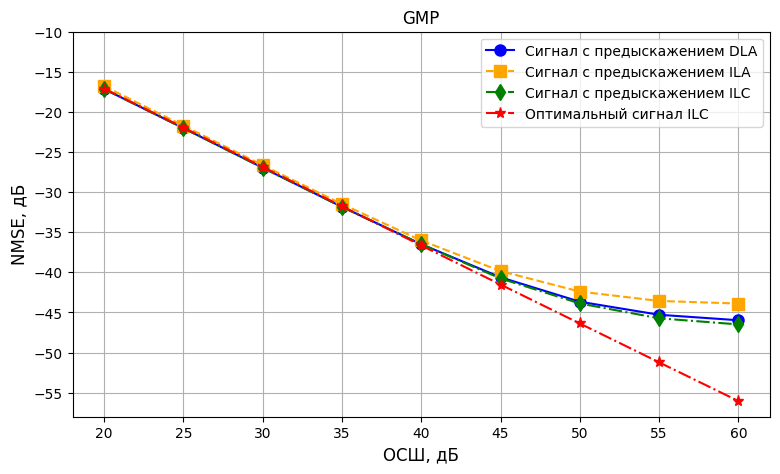

In [182]:
markersize = 8
plt.figure(figsize=(9, 5))
plt.plot(snr_range, gmp_nmse_dla_list,color='blue', linestyle='-', label="Сигнал с предыскажением DLA",
         marker='o', markersize=markersize)
plt.plot(snr_range, gmp_nmse_ila_list, color='orange', linestyle='--', label="Сигнал с предыскажением ILA",
         marker='s', markersize=markersize)
plt.plot(snr_range, gmp_nmse_ilc_list, color='green', linestyle='-.', label="Сигнал с предыскажением ILC",
         marker='d', markersize=markersize)
plt.plot(snr_range, gmp_nmse_uk_list, color='red', linestyle='-.', label="Оптимальный сигнал ILC",
         marker='*', markersize=markersize)

plt.xlabel("ОСШ, дБ", fontsize=12)
plt.ylabel("NMSE, дБ", fontsize=12)
plt.title("GMP")
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -9, 5))
plt.legend()
plt.grid(True)

plt.show()


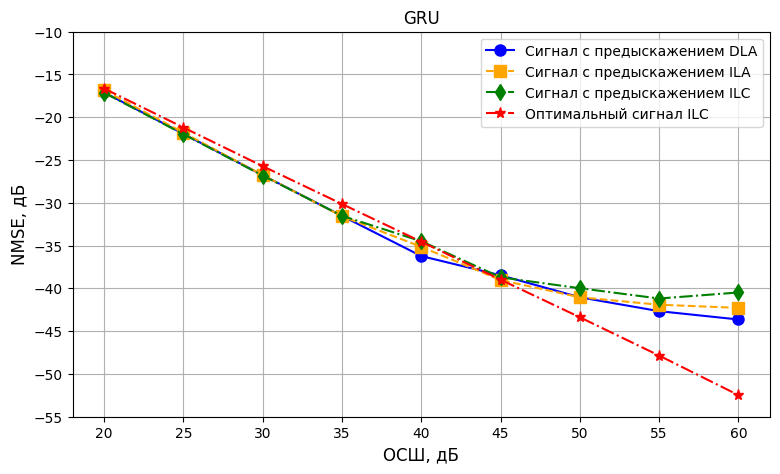

In [183]:
markersize = 8
plt.figure(figsize=(9, 5))
plt.plot(snr_range, gru_nmse_dla_list,color='blue', linestyle='-', label="Сигнал с предыскажением DLA",
         marker='o', markersize=markersize)
plt.plot(snr_range, gru_nmse_ila_list, color='orange', linestyle='--', label="Сигнал с предыскажением ILA",
         marker='s', markersize=markersize)
plt.plot(snr_range, gru_nmse_ilc_list, color='green', linestyle='-.', label="Сигнал с предыскажением ILC",
         marker='d', markersize=markersize)
plt.plot(snr_range, gru_nmse_uk_list, color='red', linestyle='-.', label="Оптимальный сигнал ILC",
         marker='*', markersize=markersize)

plt.xlabel("ОСШ, дБ", fontsize=12)
plt.ylabel("NMSE, дБ", fontsize=12)
plt.title("GRU")
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -9, 5))
plt.legend()
plt.grid(True)

plt.show()


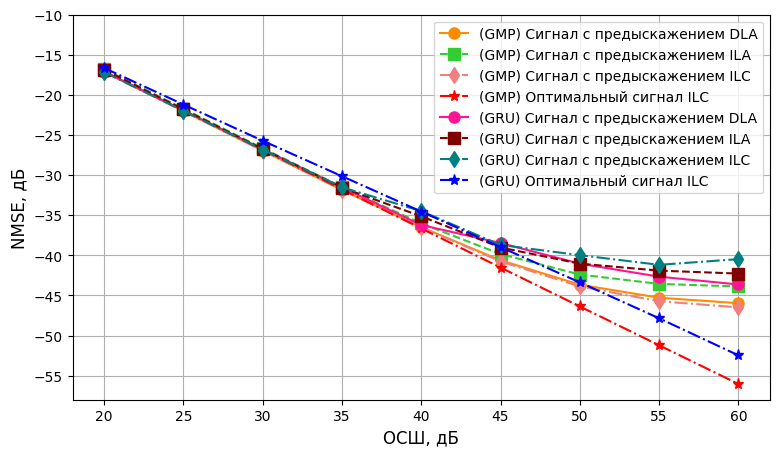

In [148]:
markersize = 8
plt.figure(figsize=(9, 5))

plt.plot(snr_range, gmp_nmse_dla_list,color='darkorange', linestyle='-', label="(GMP) Сигнал с предыскажением DLA",
         marker='o', markersize=markersize)
plt.plot(snr_range, gmp_nmse_ila_list, color='limegreen', linestyle='--', label="(GMP) Сигнал с предыскажением ILA",
         marker='s', markersize=markersize)
plt.plot(snr_range, gmp_nmse_ilc_list, color='lightcoral', linestyle='-.', label="(GMP) Сигнал с предыскажением ILC",
         marker='d', markersize=markersize)
plt.plot(snr_range, gmp_nmse_uk_list, color='red', linestyle='-.', label="(GMP) Оптимальный сигнал ILC",
         marker='*', markersize=markersize)

plt.plot(snr_range, gru_nmse_dla_list,color='deeppink', linestyle='-', label="(GRU) Сигнал с предыскажением DLA",
         marker='o', markersize=markersize)
plt.plot(snr_range, gru_nmse_ila_list, color='maroon', linestyle='--', label="(GRU) Сигнал с предыскажением ILA",
         marker='s', markersize=markersize)
plt.plot(snr_range, gru_nmse_ilc_list, color='teal', linestyle='-.', label="(GRU) Сигнал с предыскажением ILC",
         marker='d', markersize=markersize)
plt.plot(snr_range, gru_nmse_uk_list, color='blue', linestyle='-.', label="(GRU) Оптимальный сигнал ILC",
         marker='*', markersize=markersize)

plt.xlabel("ОСШ, дБ", fontsize=12)
plt.ylabel("NMSE, дБ", fontsize=12)
# plt.title("Зависимость NMSE от ОСШ")
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -9, 5))
plt.legend()
plt.grid(True)

plt.show()


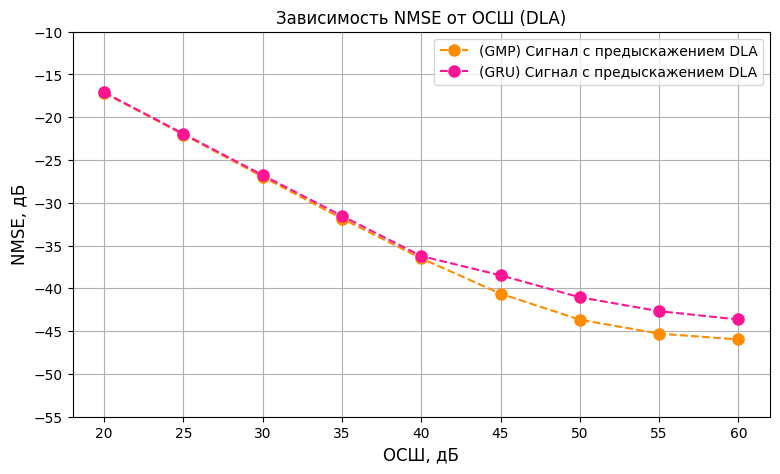

In [151]:
# DLA

markersize = 8
plt.figure(figsize=(9, 5))
plt.plot(snr_range, gmp_nmse_dla_list,color='darkorange', linestyle='--', label="(GMP) Сигнал с предыскажением DLA",
         marker='o', markersize=markersize)
plt.plot(snr_range, gru_nmse_dla_list,color='deeppink', linestyle='--', label="(GRU) Сигнал с предыскажением DLA",
         marker='o', markersize=markersize)

plt.xlabel("ОСШ, дБ", fontsize=12)
plt.ylabel("NMSE, дБ", fontsize=12)
plt.title("Зависимость NMSE от ОСШ (DLA)")
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -9, 5))
plt.legend()
plt.grid(True)

plt.show()


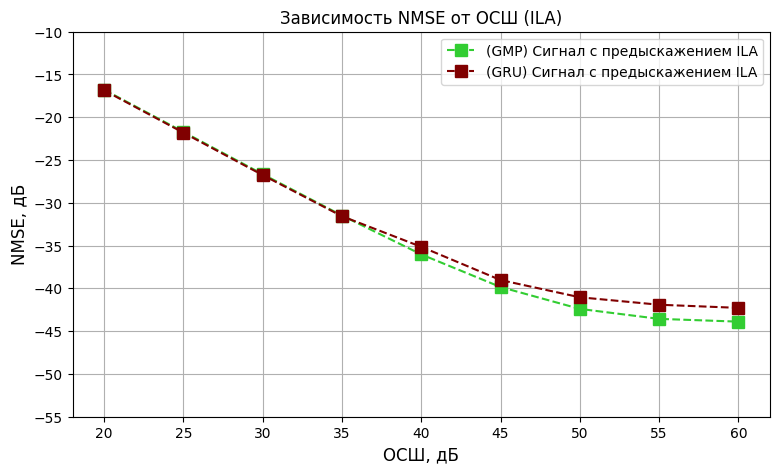

In [149]:
# ILA

markersize = 8
plt.figure(figsize=(9, 5))
plt.plot(snr_range, gmp_nmse_ila_list, color='limegreen', linestyle='--', label="(GMP) Сигнал с предыскажением ILA",
         marker='s', markersize=markersize)
plt.plot(snr_range, gru_nmse_ila_list, color='maroon', linestyle='--', label="(GRU) Сигнал с предыскажением ILA",
         marker='s', markersize=markersize)

plt.xlabel("ОСШ, дБ", fontsize=12)
plt.ylabel("NMSE, дБ", fontsize=12)
plt.title("Зависимость NMSE от ОСШ (ILA)")
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -9, 5))
plt.legend()
plt.grid(True)

plt.show()


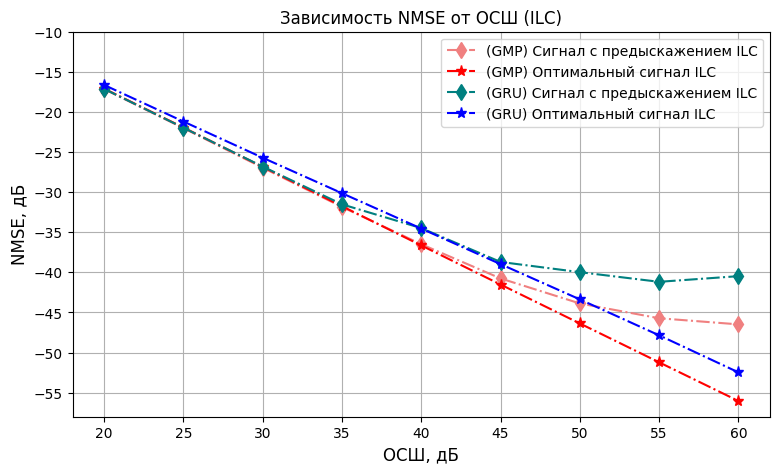

In [152]:
# ILC

markersize = 8
plt.figure(figsize=(9, 5))
plt.plot(snr_range, gmp_nmse_ilc_list, color='lightcoral', linestyle='-.', label="(GMP) Сигнал с предыскажением ILC",
         marker='d', markersize=markersize)
plt.plot(snr_range, gmp_nmse_uk_list, color='red', linestyle='-.', label="(GMP) Оптимальный сигнал ILC",
         marker='*', markersize=markersize)
plt.plot(snr_range, gru_nmse_ilc_list, color='teal', linestyle='-.', label="(GRU) Сигнал с предыскажением ILC",
         marker='d', markersize=markersize)
plt.plot(snr_range, gru_nmse_uk_list, color='blue', linestyle='-.', label="(GRU) Оптимальный сигнал ILC",
         marker='*', markersize=markersize)

plt.xlabel("ОСШ, дБ", fontsize=12)
plt.ylabel("NMSE, дБ", fontsize=12)
plt.title("Зависимость NMSE от ОСШ (ILC)")
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -9, 5))
plt.legend()
plt.grid(True)

plt.show()


ACPR

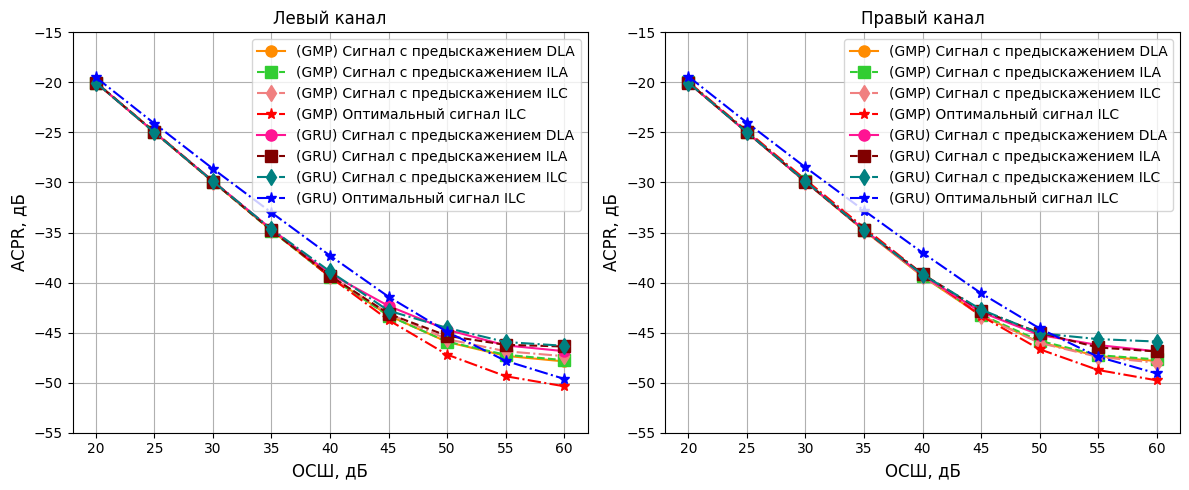

In [167]:
markersize=8
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(snr_range, gmp_acpr_left_dla_list, color='darkorange', linestyle='-', label="(GMP) Сигнал с предыскажением DLA", 
         marker='o', markersize=markersize)
plt.plot(snr_range, gmp_acpr_left_ila_list, color='limegreen', linestyle='--', label="(GMP) Сигнал с предыскажением ILA", 
         marker='s', markersize=markersize)
plt.plot(snr_range, gmp_acpr_left_ilc_list, color='lightcoral', linestyle='-.', label="(GMP) Сигнал с предыскажением ILC", 
         marker='d', markersize=markersize)
plt.plot(snr_range, gmp_acpr_left_uk_list, color='red', linestyle='-.', label="(GMP) Оптимальный сигнал ILC", 
         marker='*', markersize=markersize)
plt.plot(snr_range, gru_acpr_left_dla_list, color='deeppink', linestyle='-', label="(GRU) Сигнал с предыскажением DLA", 
         marker='o', markersize=markersize)
plt.plot(snr_range, gru_acpr_left_ila_list, color='maroon', linestyle='--', label="(GRU) Сигнал с предыскажением ILA", 
         marker='s', markersize=markersize)
plt.plot(snr_range, gru_acpr_left_ilc_list, color='teal', linestyle='-.', label="(GRU) Сигнал с предыскажением ILC", 
         marker='d', markersize=markersize)
plt.plot(snr_range, gru_acpr_left_uk_list, color='blue', linestyle='-.', label="(GRU) Оптимальный сигнал ILC", 
         marker='*', markersize=markersize)
plt.title('Левый канал', fontsize=12)
plt.xlabel('ОСШ, дБ', fontsize=12)
plt.ylabel('ACPR, дБ', fontsize=12)
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -14, 5))
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(snr_range, gmp_acpr_right_dla_list, color='darkorange', linestyle='-', label="(GMP) Сигнал с предыскажением DLA", 
         marker='o', markersize=markersize)
plt.plot(snr_range, gmp_acpr_right_ila_list, color='limegreen', linestyle='--', label="(GMP) Сигнал с предыскажением ILA", 
         marker='s', markersize=markersize)
plt.plot(snr_range, gmp_acpr_right_ilc_list, color='lightcoral', linestyle='-.', label="(GMP) Сигнал с предыскажением ILC", 
         marker='d', markersize=markersize)
plt.plot(snr_range, gmp_acpr_right_uk_list, color='red', linestyle='-.', label="(GMP) Оптимальный сигнал ILC", 
         marker='*', markersize=markersize)
plt.plot(snr_range, gru_acpr_right_dla_list, color='deeppink', linestyle='-', label="(GRU) Сигнал с предыскажением DLA", 
         marker='o', markersize=markersize)
plt.plot(snr_range, gru_acpr_right_ila_list, color='maroon', linestyle='--', label="(GRU) Сигнал с предыскажением ILA", 
         marker='s', markersize=markersize)
plt.plot(snr_range, gru_acpr_right_ilc_list, color='teal', linestyle='-.', label="(GRU) Сигнал с предыскажением ILC", 
         marker='d', markersize=markersize)
plt.plot(snr_range, gru_acpr_right_uk_list, color='blue', linestyle='-.', label="(GRU) Оптимальный сигнал ILC", 
         marker='*', markersize=markersize)
plt.title('Правый канал', fontsize=12)
plt.xlabel('ОСШ, дБ', fontsize=12)
plt.ylabel('ACPR, дБ', fontsize=12)
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -14, 5))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

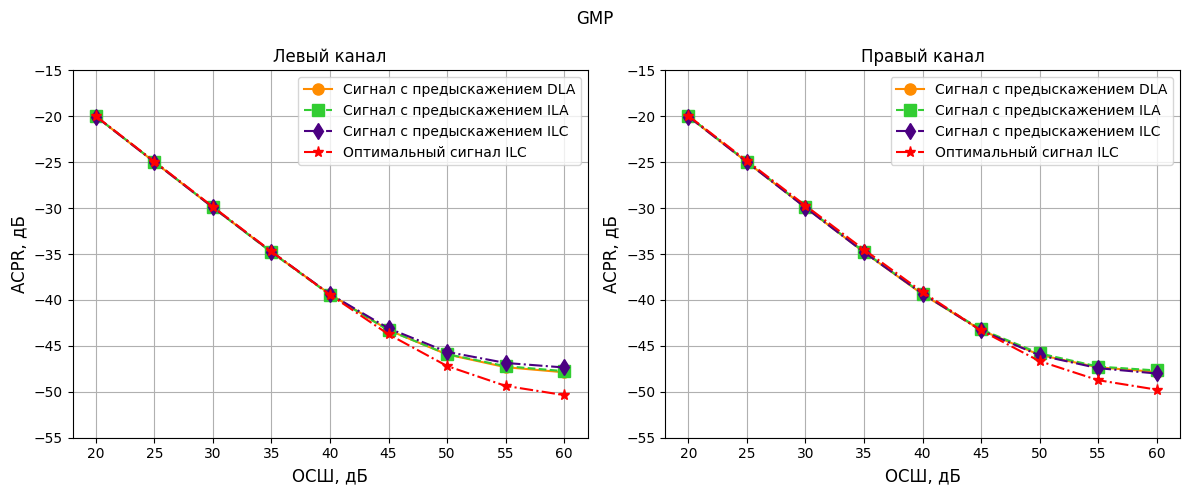

In [189]:
markersize=8
plt.figure(figsize=(12, 5))

plt.suptitle("GMP")
plt.subplot(1, 2, 1)
plt.plot(snr_range, gmp_acpr_left_dla_list, color='darkorange', linestyle='-', label="Сигнал с предыскажением DLA", 
         marker='o', markersize=markersize)
plt.plot(snr_range, gmp_acpr_left_ila_list, color='limegreen', linestyle='--', label="Сигнал с предыскажением ILA", 
         marker='s', markersize=markersize)
plt.plot(snr_range, gmp_acpr_left_ilc_list, color='indigo', linestyle='-.', label="Сигнал с предыскажением ILC", 
         marker='d', markersize=markersize)
plt.plot(snr_range, gmp_acpr_left_uk_list, color='red', linestyle='-.', label="Оптимальный сигнал ILC", 
         marker='*', markersize=markersize)
plt.title('Левый канал', fontsize=12)
plt.xlabel('ОСШ, дБ', fontsize=12)
plt.ylabel('ACPR, дБ', fontsize=12)
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -14, 5))
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(snr_range, gmp_acpr_right_dla_list, color='darkorange', linestyle='-', label="Сигнал с предыскажением DLA", 
         marker='o', markersize=markersize)
plt.plot(snr_range, gmp_acpr_right_ila_list, color='limegreen', linestyle='--', label="Сигнал с предыскажением ILA", 
         marker='s', markersize=markersize)
plt.plot(snr_range, gmp_acpr_right_ilc_list, color='indigo', linestyle='-.', label="Сигнал с предыскажением ILC", 
         marker='d', markersize=markersize)
plt.plot(snr_range, gmp_acpr_right_uk_list, color='red', linestyle='-.', label="Оптимальный сигнал ILC", 
         marker='*', markersize=markersize)
plt.title('Правый канал', fontsize=12)
plt.xlabel('ОСШ, дБ', fontsize=12)
plt.ylabel('ACPR, дБ', fontsize=12)
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -14, 5))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

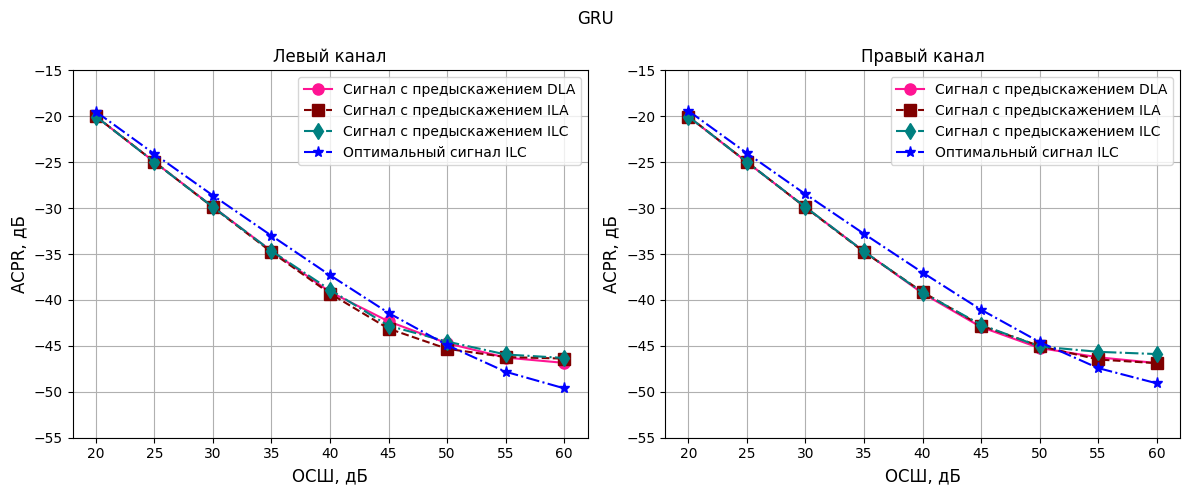

In [190]:
markersize=8
plt.figure(figsize=(12, 5))

plt.suptitle("GRU")
plt.subplot(1, 2, 1)
plt.plot(snr_range, gru_acpr_left_dla_list, color='deeppink', linestyle='-', label="Сигнал с предыскажением DLA", 
         marker='o', markersize=markersize)
plt.plot(snr_range, gru_acpr_left_ila_list, color='maroon', linestyle='--', label="Сигнал с предыскажением ILA", 
         marker='s', markersize=markersize)
plt.plot(snr_range, gru_acpr_left_ilc_list, color='teal', linestyle='-.', label="Сигнал с предыскажением ILC", 
         marker='d', markersize=markersize)
plt.plot(snr_range, gru_acpr_left_uk_list, color='blue', linestyle='-.', label="Оптимальный сигнал ILC", 
         marker='*', markersize=markersize)
plt.title('Левый канал', fontsize=12)
plt.xlabel('ОСШ, дБ', fontsize=12)
plt.ylabel('ACPR, дБ', fontsize=12)
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -14, 5))
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(snr_range, gru_acpr_right_dla_list, color='deeppink', linestyle='-', label="Сигнал с предыскажением DLA", 
         marker='o', markersize=markersize)
plt.plot(snr_range, gru_acpr_right_ila_list, color='maroon', linestyle='--', label="Сигнал с предыскажением ILA", 
         marker='s', markersize=markersize)
plt.plot(snr_range, gru_acpr_right_ilc_list, color='teal', linestyle='-.', label="Сигнал с предыскажением ILC", 
         marker='d', markersize=markersize)
plt.plot(snr_range, gru_acpr_right_uk_list, color='blue', linestyle='-.', label="Оптимальный сигнал ILC", 
         marker='*', markersize=markersize)
plt.title('Правый канал', fontsize=12)
plt.xlabel('ОСШ, дБ', fontsize=12)
plt.ylabel('ACPR, дБ', fontsize=12)
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -14, 5))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

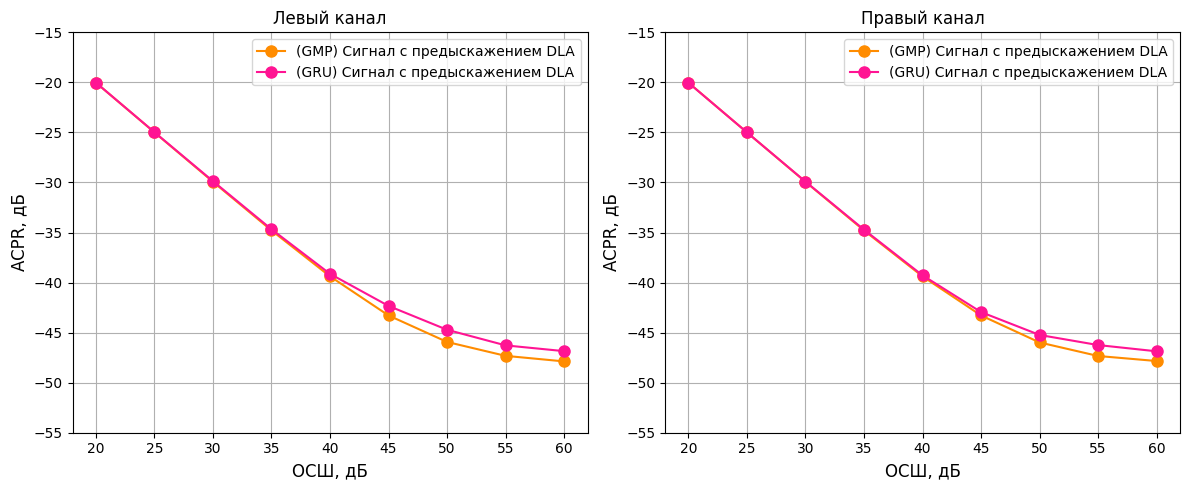

In [155]:
# DLA

markersize=8
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(snr_range, gmp_acpr_left_dla_list, color='darkorange', linestyle='-', label="(GMP) Сигнал с предыскажением DLA", 
         marker='o', markersize=markersize)
plt.plot(snr_range, gru_acpr_left_dla_list, color='deeppink', linestyle='-', label="(GRU) Сигнал с предыскажением DLA", 
         marker='o', markersize=markersize)
plt.title('Левый канал', fontsize=12)
plt.xlabel('ОСШ, дБ', fontsize=12)
plt.ylabel('ACPR, дБ', fontsize=12)
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -14, 5))
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(snr_range, gmp_acpr_right_dla_list, color='darkorange', linestyle='-', label="(GMP) Сигнал с предыскажением DLA", 
         marker='o', markersize=markersize)
plt.plot(snr_range, gru_acpr_right_dla_list, color='deeppink', linestyle='-', label="(GRU) Сигнал с предыскажением DLA", 
         marker='o', markersize=markersize)
plt.title('Правый канал', fontsize=12)
plt.xlabel('ОСШ, дБ', fontsize=12)
plt.ylabel('ACPR, дБ', fontsize=12)
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -14, 5))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

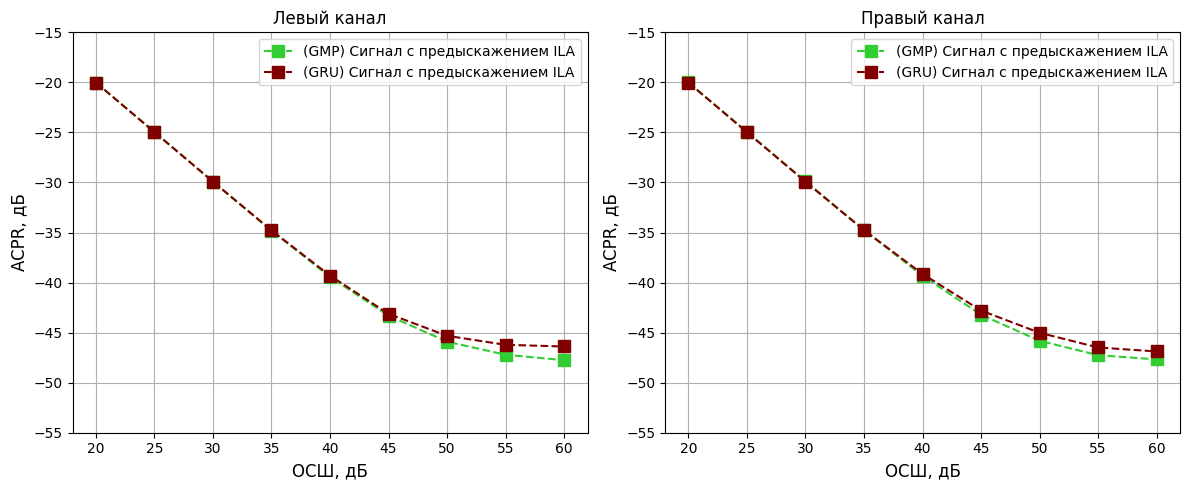

In [171]:
# ILA

markersize=8
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(snr_range, gmp_acpr_left_ila_list, color='limegreen', linestyle='--', label="(GMP) Сигнал с предыскажением ILA", 
         marker='s', markersize=markersize)
plt.plot(snr_range, gru_acpr_left_ila_list, color='maroon', linestyle='--', label="(GRU) Сигнал с предыскажением ILA", 
         marker='s', markersize=markersize)
plt.title('Левый канал', fontsize=12)
plt.xlabel('ОСШ, дБ', fontsize=12)
plt.ylabel('ACPR, дБ', fontsize=12)
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -14, 5))
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(snr_range, gmp_acpr_right_ila_list, color='limegreen', linestyle='--', label="(GMP) Сигнал с предыскажением ILA", 
         marker='s', markersize=markersize)
plt.plot(snr_range, gru_acpr_right_ila_list, color='maroon', linestyle='--', label="(GRU) Сигнал с предыскажением ILA", 
         marker='s', markersize=markersize)
plt.title('Правый канал', fontsize=12)
plt.xlabel('ОСШ, дБ', fontsize=12)
plt.ylabel('ACPR, дБ', fontsize=12)
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -14, 5))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

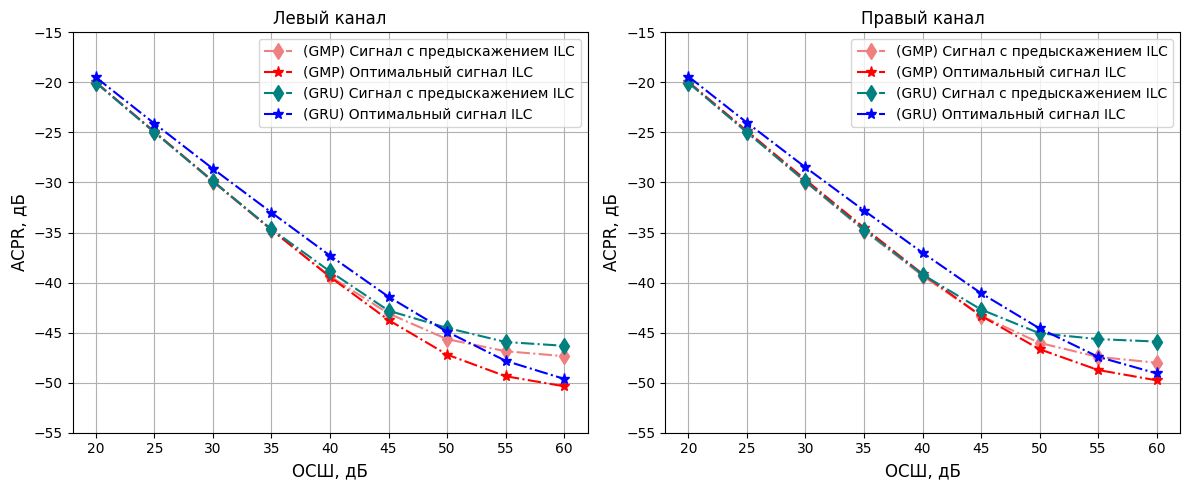

In [157]:
# ILС

markersize=8
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(snr_range, gmp_acpr_left_ilc_list, color='lightcoral', linestyle='-.', label="(GMP) Сигнал с предыскажением ILC", 
         marker='d', markersize=markersize)
plt.plot(snr_range, gmp_acpr_left_uk_list, color='red', linestyle='-.', label="(GMP) Оптимальный сигнал ILC", 
         marker='*', markersize=markersize)
plt.plot(snr_range, gru_acpr_left_ilc_list, color='teal', linestyle='-.', label="(GRU) Сигнал с предыскажением ILC", 
         marker='d', markersize=markersize)
plt.plot(snr_range, gru_acpr_left_uk_list, color='blue', linestyle='-.', label="(GRU) Оптимальный сигнал ILC", 
         marker='*', markersize=markersize)
plt.title('Левый канал', fontsize=12)
plt.xlabel('ОСШ, дБ', fontsize=12)
plt.ylabel('ACPR, дБ', fontsize=12)
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -14, 5))
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(snr_range, gmp_acpr_right_ilc_list, color='lightcoral', linestyle='-.', label="(GMP) Сигнал с предыскажением ILC", 
         marker='d', markersize=markersize)
plt.plot(snr_range, gmp_acpr_right_uk_list, color='red', linestyle='-.', label="(GMP) Оптимальный сигнал ILC", 
         marker='*', markersize=markersize)
plt.plot(snr_range, gru_acpr_right_ilc_list, color='teal', linestyle='-.', label="(GRU) Сигнал с предыскажением ILC", 
         marker='d', markersize=markersize)
plt.plot(snr_range, gru_acpr_right_uk_list, color='blue', linestyle='-.', label="(GRU) Оптимальный сигнал ILC", 
         marker='*', markersize=markersize)
plt.title('Правый канал', fontsize=12)
plt.xlabel('ОСШ, дБ', fontsize=12)
plt.ylabel('ACPR, дБ', fontsize=12)
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -14, 5))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()